In [29]:
import torch
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import random

In [4]:
# 获取数据集
mnist_train = torchvision.datasets.FashionMNIST(root='E:/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='E:/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

In [6]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

feature, label = mnist_train[0]
print(feature.shape, label)

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000
torch.Size([1, 28, 28]) 9


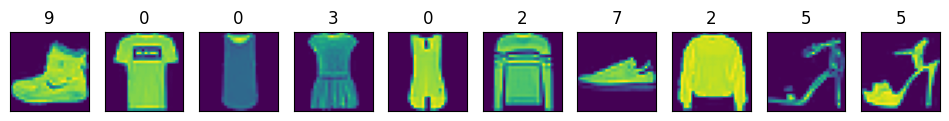

In [10]:
# 画图看看
def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=[12, 12])
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view([28, 28]).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
    
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, y)

In [22]:
# 读取小批量
if sys.platform.startswith('win'): # Windows系统使用多线程读数据可能会有问题
    num_workers = 0
else:
    num_workers = 4
    
batch_size = 256
train_iter = Data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = Data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [44]:
# 查看读取速度
start = time.time()
for X, y in train_iter:
    continue
print(f'{time.time() - start:.2f} sec')

5.34 sec


In [96]:
# 初始化模型参数
num_inputs = 28 * 28
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, [num_inputs, num_outputs]), dtype=torch.float32, requires_grad=True)
b = torch.zeros([num_outputs], dtype=torch.float32, requires_grad=True)

In [31]:
# 实现Softmax运算
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

In [32]:
# 定义模型
def net(X):
    return softmax(torch.mm(X.view(-1, num_inputs), W) + b)

In [114]:
# 定义损失函数
# y_hat = torch.Tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# y = torch.LongTensor([0, 2])
# y_hat.gather(1, y.view(-1, 1))
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1, y.view(-1, 1)))

In [81]:
# 定义随机梯度下降
def sgd(params, batch_size, lr):
    for param in params:
        param.data -= param.grad / batch_size * lr

In [93]:
# 计算准确率
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().sum().item()

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

# a = torch.Tensor([[0.1, 0.5, 0.2], [0.2, 0.6, 0.1]])
# [a[i][j] for i, j in zip(range(a.shape[0]), a.argmax(dim=1))]

In [97]:
# 训练模型
num_epochs, lr = 5, 0.1

for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X)
        l = cross_entropy(y_hat, y).sum()
        
        l.backward()
        sgd([W, b], batch_size, lr)
        W.grad.data.zero_()
        b.grad.data.zero_()
        
        train_l_sum += l
        train_acc_sum += accuracy(net(X), y)
        n += y.shape[0]
    print(f'epoch {epoch + 1: d}, loss {train_l_sum / n: .2f}, train_acc {train_acc_sum / n: .2f}, test_acc {evaluate_accuracy(test_iter, net)}')
        

epoch  1, loss  0.79, train_acc  0.76, test_acc 0.7947
epoch  2, loss  0.57, train_acc  0.82, test_acc 0.8085
epoch  3, loss  0.52, train_acc  0.83, test_acc 0.8174
epoch  4, loss  0.50, train_acc  0.84, test_acc 0.8245
epoch  5, loss  0.49, train_acc  0.84, test_acc 0.8253


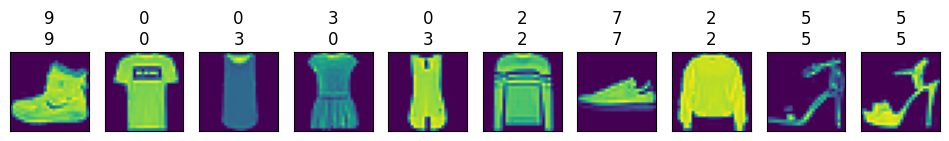

In [112]:
# 预测
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(str(mnist_train[i][1]) + '\n' + str(net(mnist_train[i][0].view(1, -1)).argmax(dim=1).item())) 
show_fashion_mnist(X, y)